# **Exploratory Data Analysis**

## **1. Data Overview**

In [2]:
import pandas as pd
import numpy as np

### **1.1 Dataset Source**

This analysis uses the Online Shoppers Purchasing Intention Dataset from:

> Sakar, C.O., Polat, S.O., Katircioglu, M. and Kastro, Y., 2019. 
> Real-time prediction of online shoppers' purchasing intention using 
> multilayer perceptron and LSTM recurrent neural networks. 
> Neural Computing and Applications, 31(6), pp.6893-6908.

The dataset contains 12,330 sessions from an online retailer with 
behavioral and session-based features.

### **1.2 Sanity Check**

In [3]:
# Load the data
df = pd.read_csv('../data/online_shoppers_intention.csv')

In [4]:
# Data shape
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 12330
Number of columns: 18


In [5]:
# Check for missing values
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [6]:
# Check column data types
print("Column Data Types:")
for col in df.columns:
    print(f"{col:30s} : {str(df[col].dtype)}")

Column Data Types:
Administrative                 : int64
Administrative_Duration        : float64
Informational                  : int64
Informational_Duration         : float64
ProductRelated                 : int64
ProductRelated_Duration        : float64
BounceRates                    : float64
ExitRates                      : float64
PageValues                     : float64
SpecialDay                     : float64
Month                          : object
OperatingSystems               : int64
Browser                        : int64
Region                         : int64
TrafficType                    : int64
VisitorType                    : object
Weekend                        : bool
Revenue                        : bool


### **1.3 Feature Definitions**

#### **Behavioral Features (Page Counts and Duration)**

**Administrative** (int)
- Number of pages visited about account management (login, profile, settings)

**Administrative_Duration** (float)
- Total time spent (seconds) on administrative pages

**Informational** (int)
- Number of pages visited about website information (About Us, Contact, FAQ)

**Informational_Duration** (float)
- Total time spent (seconds) on informational pages

**ProductRelated** (int)
- Number of product pages visited (product listings, product details)

**ProductRelated_Duration** (float)
- Total time spent (seconds) on product-related pages

---

#### **Google Analytics Metrics (Historical Averages)**

**BounceRates** (float, 0-0.2)
- Average bounce rate of pages visited in this session
- Bounce rate = % of visitors who enter the site from that page and leave without triggering any other requests
- Based on historical data from Google Analytics
- Low bounce rate = engaging pages

**ExitRates** (float, 0-0.2)
- Average exit rate of pages visited in this session
- Exit rate = % of pageviews on that page that were the last in the session
- Based on historical data from Google Analytics
- Low exit rate = pages deeper in sales funnel

**PageValues** (float, 0-361)
- Average value of pages visited in this session
- Represents the average value for a page that a user visited before completing an e-commerce transaction
- Based on historical data from Google Analytics
- High page value = high-conversion pages (cart, checkout)
- 0 = low-value pages (78% of sessions)
- **Note:** This is historical data from past users, NOT from current session

---

#### **Temporal Features**

**SpecialDay** (float, 0-1.0)
- Closeness of the site visiting time to a special day (e.g., Mother's Day, Valentine's Day)
- Value increases as the special day approaches, peaks on the day itself
- Takes non-zero values between 2-12 days before special days
- Maximum value of 1.0 on the special day itself

**Month** (string)
- Month of the visit (Feb, Mar, May, June, Jul, Aug, Sep, Oct, Nov, Dec)

**Weekend** (boolean)
- True if the visit occurred on Saturday or Sunday
- False if weekday

---

#### **Visitor & Session Information**

**VisitorType** (categorical, 3 categories)
- "Returning_Visitor": Has visited the site before
- "New_Visitor": First time visiting the site
- "Other": Other classification

**OperatingSystems** (int, 8 categories)
- Operating system used by the visitor (Windows, Mac, Linux, etc.)
- Encoded as integers 1-8

**Browser** (int, 13 categories)
- Browser used by the visitor (Chrome, Firefox, Safari, etc.)
- Encoded as integers 1-13

**Region** (int, 9 categories)
- Geographic region from which the session originated
- Encoded as integers 1-9

**TrafficType** (int, 20 categories)
- Traffic source that brought the visitor to the website
- Examples: banner ad, SMS, direct (typed URL), search engine, social media
- Encoded as integers 1-20

---

#### **Target Variable**

**Revenue** (boolean)
- **True**: Session ended with a purchase (conversion)
- **False**: Session ended without a purchase
- This is what we're trying to predict

## **2. Target Variable: Revenue (Label (y))**

### Question: Can we predict which visitors will make a purchase?

`Revenue` (Boolean)
- True = Customer completed a purchase
- False = Customer browsed but didn't buy

In [7]:
# How many purchases vs non-purchases?
revenue_counts = df['Revenue'].value_counts()
print(f"{revenue_counts}\n")
revenue_percentages = df['Revenue'].value_counts(normalize=True) * 100
print(revenue_percentages)

print(f"\nConversion Rate: {revenue_percentages[True]:.1f}%")

Revenue
False    10422
True      1908
Name: count, dtype: int64

Revenue
False    84.525547
True     15.474453
Name: proportion, dtype: float64

Conversion Rate: 15.5%


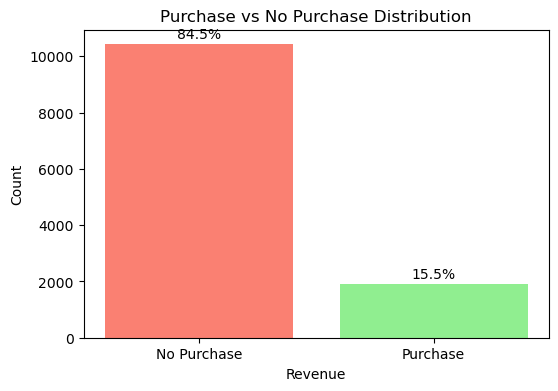

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
bars = plt.bar(['No Purchase', 'Purchase'], 
               [revenue_counts[False], revenue_counts[True]], 
               color=['salmon', 'lightgreen'])

plt.text(0, revenue_counts[False] + 200, f'{revenue_percentages[False]:.1f}%', ha='center')
plt.text(1, revenue_counts[True] + 200, f'{revenue_percentages[True]:.1f}%', ha='center')

plt.title('Purchase vs No Purchase Distribution')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

### **Interpretation**

**1. Conversion rate**

The conversion rate is **15.5%**, meaning roughly 1 in 6 visitors actually make a purchase.

**2. Baseline Accuracy**

The class distribution above tells us the baseline accuracy we need to beat. A naive classifier that always predicts the majority class (`Revenue = False`) would achieve around 84.5% accuracy simply by predicting that no visitor will make a purchase.

**3. Imbalanced Data and Metric Selection**

The data for revenue is imbalanced, where the majority class (No Purchase) makes up 84.5% of the data, well above the 80% threshold that typically indicates imbalance.

Because of this imbalance, accuracy will be misleading. A standard model will bias towards precisely predicting the majority class (No Purchase) instead of the minority class (Purchase), but what we truly want to predict is a person's purchase intent as a buyer.

Therefore, we should focus on metrics designed for imbalanced data:
- **Precision**: Of all predicted purchases, how many were actual purchases? (Avoids wasting marketing spend on non-buyers)
- **Recall**: Of all actual purchases, how many did we correctly identify? (Avoids missing potential customers)
- **F1-Score**: Harmonic mean of precision and recall, balances both concerns
- **ROC-AUC**: Measures the model's ability to distinguish between classes across all thresholds
- **Precision-Recall AUC**: More informative than ROC-AUC for imbalanced data

## **3. Feature Distributions**

### **3.1 Numerical Features**

Features to analyze:
- Administrative, Administrative_Duration
- Informational, Informational_Duration
- ProductRelated, ProductRelated_Duration
- BounceRates, ExitRates, PageValues, SpecialDay

In [9]:
# Select only numerical columns (exclude categorical-like features that use numerical values when recorded)
categorical_like = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']
numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns 
                  if col not in categorical_like]
print(f"Numerical columns: {numerical_cols}")

df[numerical_cols].describe()

Numerical columns: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


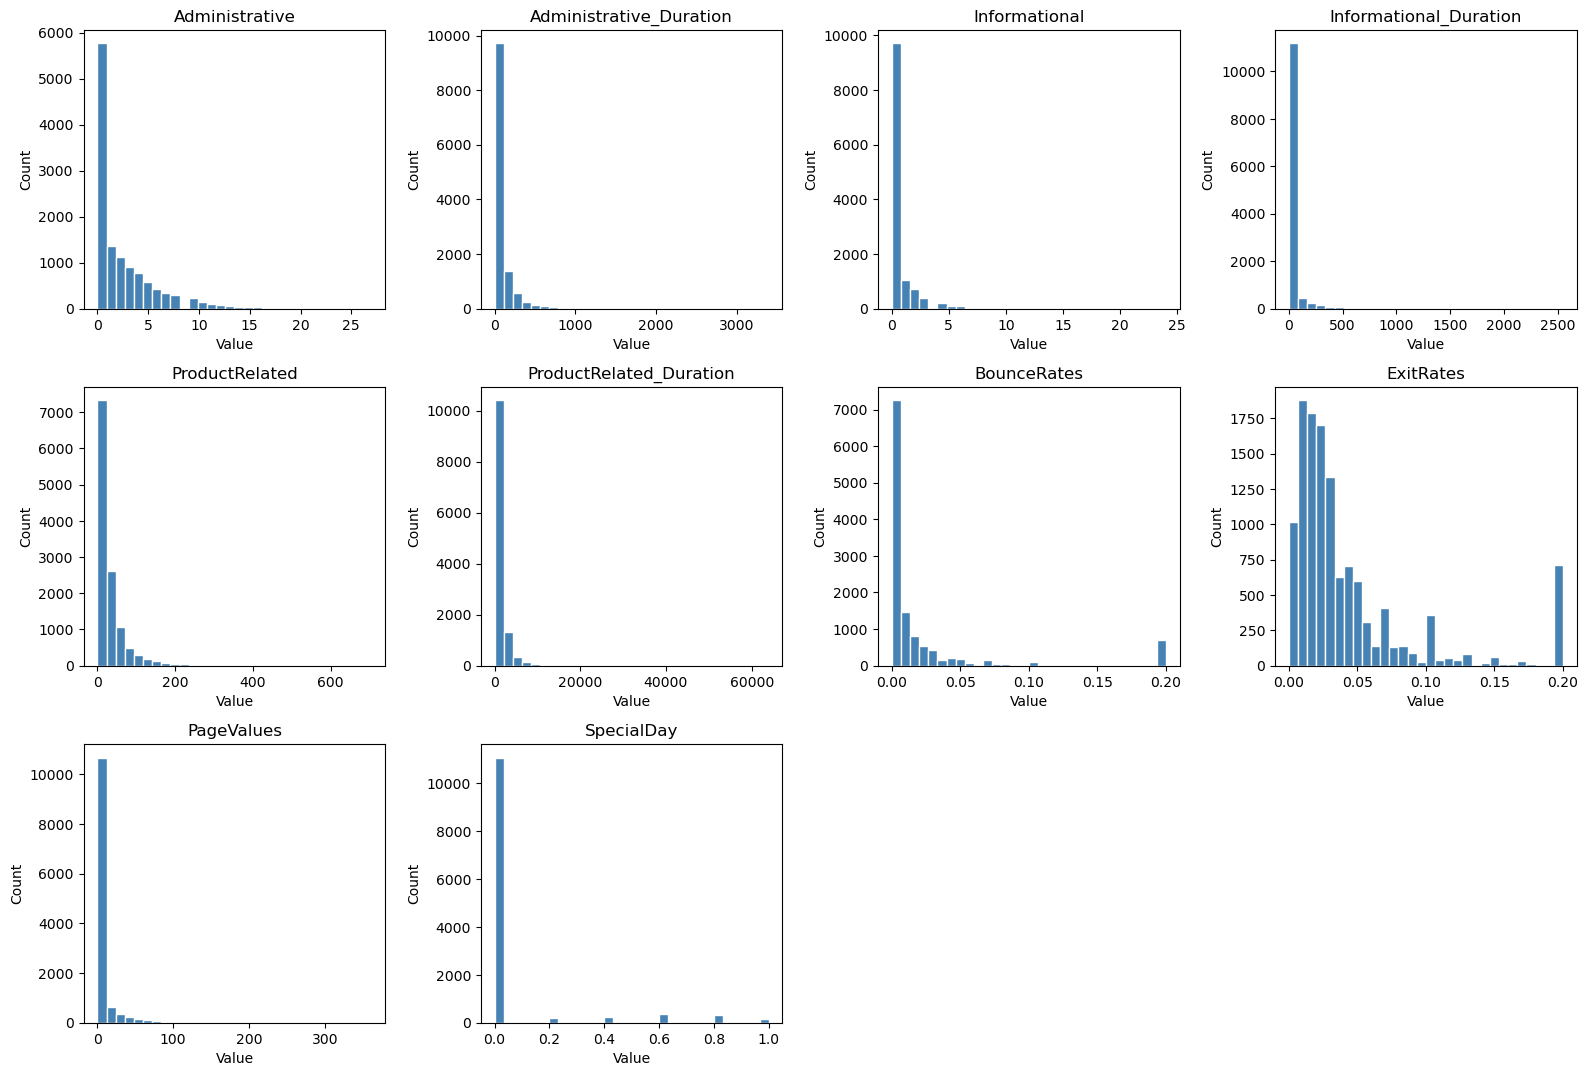

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col], bins=30, color='steelblue', edgecolor='white')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

for j in range(len(numerical_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### **Interpretation**

**1. Right-Skewed Distributions**

Nearly all numerical features are right-skewed, meaning most users have low values with a long tail of high values. This is typical for web behavior data because most visitors browse briefly while only a small portion engages deeply. Some features like `PageValues` are also zero-inflated, where most sessions have zero value.

**2. Outliers**

Duration features (`Administrative_Duration`, `Informational_Duration`, `ProductRelated_Duration`) have extremely large outliers, which are a few users with unusually long session times.

### **3.2 Categorical Features**

Features to analyze:
- Month, Weekend (Boolean)
- VisitorType (String)
- OperatingSystems, Browser, Region, TrafficType (Numerical)

In [11]:
categorical_cols = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']

for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"Unique values: {df[col].nunique()}")


Month:
Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64
Unique values: 10

VisitorType:
VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64
Unique values: 3

Weekend:
Weekend
False    9462
True     2868
Name: count, dtype: int64
Unique values: 2

OperatingSystems:
OperatingSystems
2    6601
1    2585
3    2555
4     478
8      79
6      19
7       7
5       6
Name: count, dtype: int64
Unique values: 8

Browser:
Browser
2     7961
1     2462
4      736
5      467
6      174
10     163
8      135
3      105
13      61
7       49
12      10
11       6
9        1
Name: count, dtype: int64
Unique values: 13

Region:
Region
1    4780
3    2403
4    1182
2    1136
6     805
7     761
9     511
8     434
5     318
Name: count, dtype: int64
Unique values: 9

TrafficType:
TrafficType
2     3913
1     2451
3     2052
4

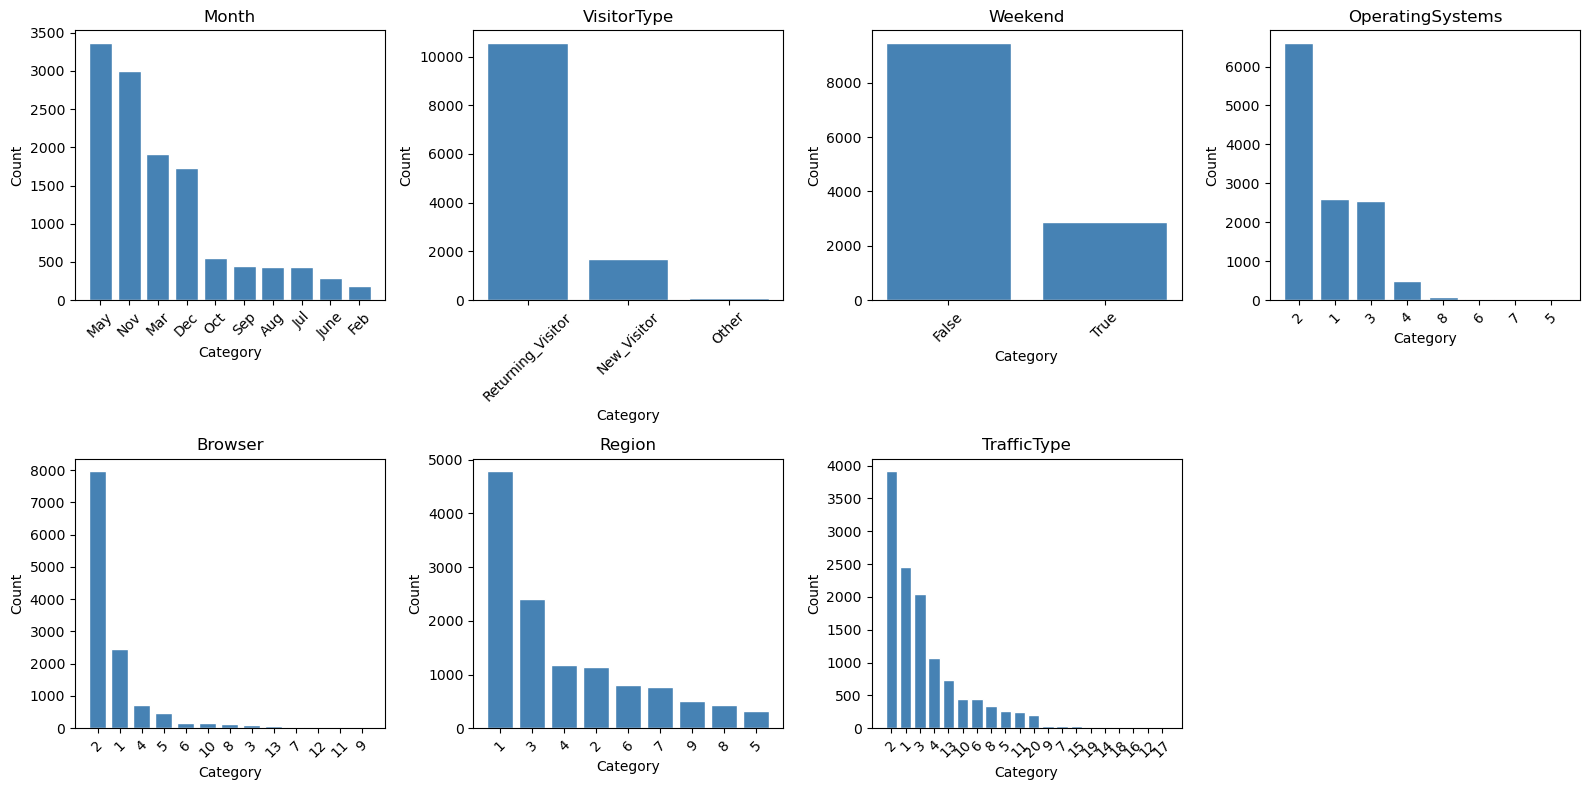

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    counts = df[col].value_counts()
    axes[i].bar(counts.index.astype(str), counts.values, color='steelblue', edgecolor='white')
    axes[i].set_title(col)
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### **Interpretation**

- **Month**: May and November have the highest traffic, likely due to seasonal shopping; February has the lowest.
- **VisitorType**: Returning visitors dominate.
- **Weekend**: Most visits occur on weekdays.
- **OperatingSystems**: One or two OS types dominate, likely Windows, Mac, etc.
- **Browser**: Browser 2 dominates heavily, likely Chrome.
- **Region**: Region 1 has the most users, but sessions are relatively 
  spread across regions.
- **TrafficType**: Types 1-4 account for most traffic, with a long tail of 20 total types.

## **4. Purchase Patterns**

### Question: Which features actually differentiate buyers from non-buyers

### **4.1 Numerical Features**

In [ ]:
buyers = df[df['Revenue'] == True]
non_buyers = df[df['Revenue'] == False]

comparison = []
for col in numerical_cols:
    buyer_mean = buyers[col].mean()
    non_buyer_mean = non_buyers[col].mean()
    buyer_median = buyers[col].median()
    non_buyer_median = non_buyers[col].median()
    
    comparison.append({
        'Feature': col,
        'Buyer Mean': round(buyer_mean, 2),
        'Non-Buyer Mean': round(non_buyer_mean, 2),
        'Buyer Median': round(buyer_median, 2),
        'Non-Buyer Median': round(non_buyer_median, 2)
    })

comparison_df = pd.DataFrame(comparison)
comparison_df

,Feature,Buyer Mean,Non-Buyer Mean,Buyer Median,Non-Buyer Median
0,Administrative,3.39,2.12,2.00,0.00
1,Administrative_Duration,119.48,73.74,52.37,0.00
2,Informational,0.79,0.45,0.00,0.00
3,Informational_Duration,57.61,30.24,0.00,0.00
4,ProductRelated,48.21,28.71,29.00,16.00
5,ProductRelated_Duration,1876.21,1069.99,1109.91,510.19
6,BounceRates,0.01,0.03,0.00,0.00
7,ExitRates,0.02,0.05,0.02,0.03
8,PageValues,27.26,1.98,16.76,0.00
9,SpecialDay,0.02,0.07,0.00,0.00


#### **Single-Feature AUC**

AUC (Area Under ROC Curve) directly measures how well a single feature can separate buyers from non-buyers.

- **0.5** = No predictive power (random guessing)
- **0.6 - 0.7** = Weak predictor
- **0.7 - 0.8** = Moderate predictor
- **0.8 - 0.9** = Strong predictor
- **> 0.9** = Very strong (check for data leakage)

In [ ]:
from sklearn.metrics import roc_auc_score

auc_results = []

for col in numerical_cols:
    auc = roc_auc_score(df['Revenue'], df[col])
    
    # If AUC < 0.5, the feature is inversely related (lower = more likely to buy)
    if auc < 0.5:
        auc_effective = 1 - auc
        direction = "Lower = Buy"
    else:
        auc_effective = auc
        direction = "Higher = Buy"
    
    if auc_effective < 0.6:
        strength = "Weak"
    elif auc_effective < 0.7:
        strength = "Moderate"
    elif auc_effective < 0.8:
        strength = "Good"
    elif auc_effective < 0.9:
        strength = "Strong"
    else:
        strength = "Very Strong"
    
    auc_results.append({
        'Feature': col,
        'AUC': round(auc_effective, 3),
        'Direction': direction,
        'Strength': strength
    })

auc_df = pd.DataFrame(auc_results).sort_values('AUC', ascending=False)
print("Single-Feature AUC")
print(auc_df.to_string(index=False))

Single-Feature AUC (Predictive Power)
                Feature   AUC    Direction Strength
             PageValues 0.863 Higher = Buy   Strong
              ExitRates 0.703  Lower = Buy     Good
ProductRelated_Duration 0.673 Higher = Buy Moderate
         ProductRelated 0.658 Higher = Buy Moderate
         Administrative 0.627 Higher = Buy Moderate
Administrative_Duration 0.623 Higher = Buy Moderate
            BounceRates 0.613  Lower = Buy Moderate
          Informational 0.565 Higher = Buy     Weak
 Informational_Duration 0.562 Higher = Buy     Weak
             SpecialDay 0.536  Lower = Buy     Weak


### **Interpretation**

**1. PageValues is the strongest predictor (AUC ~0.863)**

PageValues alone can separate buyers from non-buyers with 86.3% accuracy. This is suspiciously strong for a single feature, but since PageValue is based on the historical score of all past users' visits, and the current session in progress isn't a part of this historical record.

**2. Inverse relationship**

ExitRates is the second strongest (AUC ~0.703), and BouceRates is also a moderate predictor. Only these two exhibit an inverse relationship with Revenue, meaning lower ExitRates/BouceRates results in higher Revenue, which also makes sense in the real world.

Lower exit rates = more likely to buy. Buyers navigate deeper into the site rather than exiting early. This is a legitimate behavioral signal.

### **4.2 Categorical Features**

**Note:** `OperatingSystems`, `Browser`, `Region`, and `TrafficType` are excluded from this analysis because:

1. **High cardinality with severe imbalance**: Browser has 13 categories but one dominates, TrafficType has 20 categories with a long tail. Many categories have too few samples to learn meaningful patterns.

2. **Anonymous encoding limits interpretability**: The integer encodings are arbitrary and undocumented (e.g., which browser is "2"?), making feature engineering and business interpretation difficult.

3. **Low expected predictive power**: These are demographic/technical attributes rather than behavioral signals. A user's browser or OS typically doesn't indicate purchase intent the way `PageValues`, `ExitRates`, or session duration does.

In [ ]:
month_conversion = df.groupby('Month')['Revenue'].agg(['sum', 'count'])
month_conversion['conversion_rate'] = (month_conversion['sum'] / month_conversion['count']) * 100
month_conversion = month_conversion.sort_values('conversion_rate', ascending=False)

print(month_conversion)

       sum  count  conversion_rate
Month                             
Nov    760   2998        25.350233
Oct    115    549        20.947177
Sep     86    448        19.196429
Aug     76    433        17.551963
Jul     66    432        15.277778
Dec    216   1727        12.507238
May    365   3364        10.850178
June    29    288        10.069444
Mar    192   1907        10.068170
Feb      3    184         1.630435


In [ ]:
weekend_conversion = df.groupby('Weekend')['Revenue'].agg(['sum', 'count'])
weekend_conversion['conversion_rate'] = (weekend_conversion['sum'] / weekend_conversion['count']) * 100

print(weekend_conversion)

          sum  count  conversion_rate
Weekend                              
False    1409   9462        14.891144
True      499   2868        17.398884


In [ ]:
visitor_conversion = df.groupby('VisitorType')['Revenue'].agg(['sum', 'count'])
visitor_conversion['conversion_rate'] = (visitor_conversion['sum'] / visitor_conversion['count']) * 100
visitor_conversion = visitor_conversion.sort_values('conversion_rate', ascending=False)

print(visitor_conversion)

                    sum  count  conversion_rate
VisitorType                                    
New_Visitor         422   1694        24.911452
Other                16     85        18.823529
Returning_Visitor  1470  10551        13.932329


#### **Information Value (IV)**

Formula:

$$IV = \sum_{i} \left( \frac{G_i}{G} - \frac{B_i}{B} \right) \times \ln\left(\frac{G_i / G}{B_i / B}\right)$$

Where:
- $G_i$ = count of good (buyers) in category $i$
- $G$ = total count of good (buyers)
- $B_i$ = count of bad (non-buyers) in category $i$
- $B$ = total count of bad (non-buyers)

**Interpretation Thresholds:**
| IV Value | Predictive Power |
|----------|------------------|
| < 0.02 | Not useful |
| 0.02 - 0.1 | Weak |
| 0.1 - 0.3 | Medium |
| 0.3 - 0.5 | Strong |
| > 0.5 | Suspicious (check for leakage) |

In [ ]:
def calculate_iv(df, feature, target):
    """Calculate Information Value for a categorical feature."""
    
    # Get counts per category
    stats = df.groupby(feature)[target].agg(['sum', 'count'])
    stats.columns = ['buyers', 'total']
    stats['non_buyers'] = stats['total'] - stats['buyers']
    
    # Calculate percentages of total buyers/non-buyers
    total_buyers = stats['buyers'].sum()
    total_non_buyers = stats['non_buyers'].sum()
    
    stats['pct_buyers'] = stats['buyers'] / total_buyers
    stats['pct_non_buyers'] = stats['non_buyers'] / total_non_buyers
    
    # Avoid division by zero / log(0) by adding small epsilon
    eps = 0.0001
    stats['pct_buyers'] = stats['pct_buyers'].clip(lower=eps)
    stats['pct_non_buyers'] = stats['pct_non_buyers'].clip(lower=eps)
    
    # Calculate WoE and IV contribution for each category
    stats['woe'] = np.log(stats['pct_buyers'] / stats['pct_non_buyers'])
    stats['iv_contribution'] = (stats['pct_buyers'] - stats['pct_non_buyers']) * stats['woe']
    
    # Total IV
    iv = stats['iv_contribution'].sum()
    
    return iv, stats

categorical_features = ['Month', 'VisitorType', 'Weekend']

iv_results = []
for feature in categorical_features:
    iv, details = calculate_iv(df, feature, 'Revenue')
    
    if iv < 0.02:
        strength = "Not useful"
    elif iv < 0.1:
        strength = "Weak"
    elif iv < 0.3:
        strength = "Medium"
    elif iv < 0.5:
        strength = "Strong"
    else:
        strength = "⚠️ Suspicious"
    
    iv_results.append({
        'Feature': feature,
        'IV': round(iv, 4),
        'Strength': strength
    })

iv_df = pd.DataFrame(iv_results).sort_values('IV', ascending=False)
print("Information Value (IV) Results")
print(iv_df.to_string(index=False))

Information Value (IV) Results
    Feature     IV   Strength
      Month 0.2452     Medium
VisitorType 0.0718       Weak
    Weekend 0.0063 Not useful


### **Interpretation**

**1. Month is the most useful categorical predictor (IV = 0.2452)**

November has the highest conversion (25.4%), February the lowest (1.6%). This 24% spread is very possibly driven by seasonal shopping (Black Friday, holidays).

**2. VisitorType has weak predictive power (IV = 0.0718)**

Surprisingly, new visitors convert much better (24.9%) than returning visitors (13.9%), which is quite conterintuitive, but 86% of sessions are returning visitors and IV is weak, limiting practical utility. Thus, I will test both including and not including it in my model.

**3. Weekend is not useful (IV = 0.0063)**

Weekend and weekday visits have very similar in conversion rate. Statistically significant but practically useless.